# PyTorch Model Deployment

## 0. Get setup

In [2]:
import torch
import torchvision

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 39.70 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


## 1. Getting Data

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment exepriment outline

### 3 questions:
1. what is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

## 3. Creating an EffNetB2 feature extractor

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:

def create_effnetb2_model(num_classes:int=3,
                          device=device):
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = effnetb2_weights.transforms()

  effnetb2_model = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

  for param in effnetb2_model.parameters():
    param.requires_grad = False

  effnetb2_model.classifier = nn.Sequential(
      nn.Dropout(p=.3, inplace=True),
      nn.Linear(in_features=1408,
                out_features=num_classes,
                bias=True)
  )

  return effnetb2_model.to(device), effnetb2_transforms

effnetb2, effnetb2_transforms = create_effnetb2_model(3,
                                                      device)
summary(model=effnetb2,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=['var_names'],
        input_size=(32, 3, 224, 224))


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 3.2 Create DataLoaders for EffNetB2

In [21]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=effnetb2_transforms,
                                                                               batch_size=32)

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cf11fc27c40>,
 ['pizza', 'steak', 'sushi'])

### 3.3 Training effnetb2 feature extractor

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb2.parameters(),
                             lr=0.001)

epochs = 10
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=epochs,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9482 | train_acc: 0.5896 | test_loss: 0.7444 | test_acc: 0.9006
Epoch: 2 | train_loss: 0.7333 | train_acc: 0.7750 | test_loss: 0.5977 | test_acc: 0.9256
Epoch: 3 | train_loss: 0.6372 | train_acc: 0.8500 | test_loss: 0.5264 | test_acc: 0.9284
Epoch: 4 | train_loss: 0.4799 | train_acc: 0.8750 | test_loss: 0.4485 | test_acc: 0.9227
Epoch: 5 | train_loss: 0.4419 | train_acc: 0.9104 | test_loss: 0.4123 | test_acc: 0.9472
Epoch: 6 | train_loss: 0.3685 | train_acc: 0.9333 | test_loss: 0.3761 | test_acc: 0.9534
Epoch: 7 | train_loss: 0.4089 | train_acc: 0.8708 | test_loss: 0.3324 | test_acc: 0.9472
Epoch: 8 | train_loss: 0.3423 | train_acc: 0.9187 | test_loss: 0.3242 | test_acc: 0.9409
Epoch: 9 | train_loss: 0.3107 | train_acc: 0.9250 | test_loss: 0.3101 | test_acc: 0.9563
Epoch: 10 | train_loss: 0.3642 | train_acc: 0.8771 | test_loss: 0.3090 | test_acc: 0.9256


### 3.4 Inspecting Effnetb2 loss curves

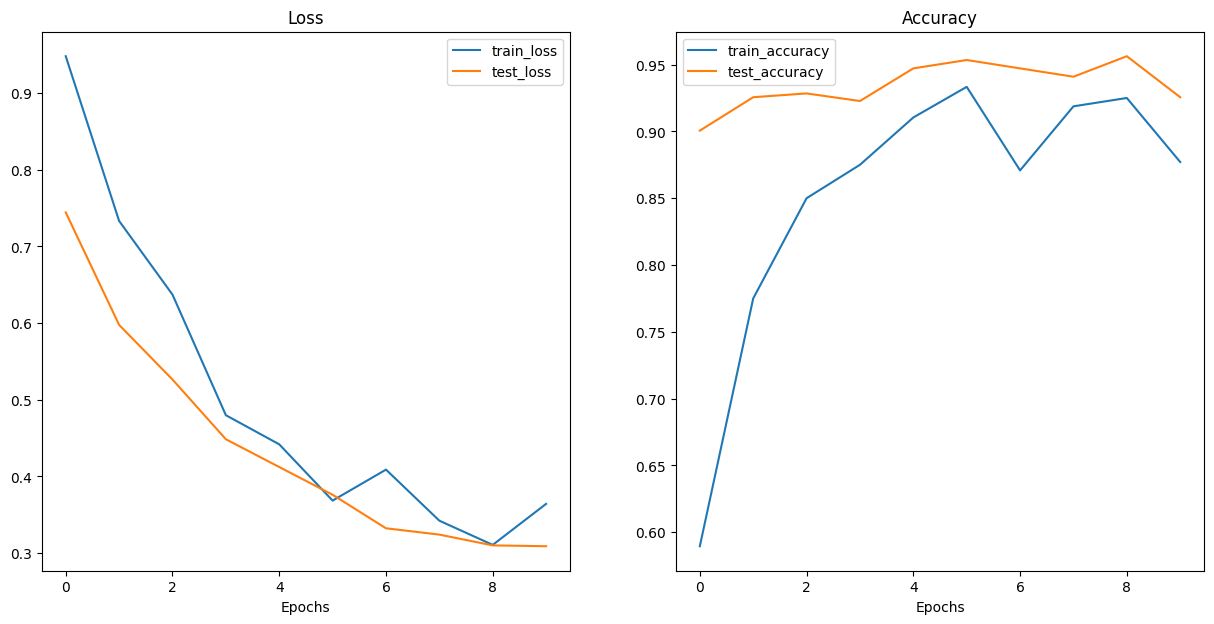

In [23]:
plot_loss_curves(effnetb2_results)

### 3.5 Saving effnetb2 feature extractor

In [24]:
from going_modular.going_modular import utils
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrainet_effnetb2.pth")

[INFO] Saving model to: models/pretrainet_effnetb2.pth


### 3.6 Inspecting the size of our effnetb2 feature extractor

In [31]:
from pathlib import Path
pretrained_effnetb2_model_size = Path("models/pretrainet_effnetb2.pth").stat().st_size / (1024*1024)
print(f"Pretrained effnetb2 size: {pretrained_effnetb2_model_size:.2f} MB")

Pretrained effnetb2 size: 29.83 MB


### 3.7 Collecting EffNetB2 feature extractor states

In [33]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [34]:
effnetb2_stats = {"test_loss":effnetb2_results["test_loss"][-1],
                  "test_acc":effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.30899556875228884,
 'test_acc': 0.9255681818181818,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.83111000061035}